In [1]:
#@title Data retrieval
from matplotlib import rcParams
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.fft import fft, fftfreq, irfft, ifft
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from utils.utils import load_data
from utils.plot_utils import *
from data_preprocessing import Preprocessing
from channel_selection import ChannelSelection
from regression_models import RegressionModels


rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Extract principal component of the data (PCA)

In order to reduce the dimensionality of the input data (60 channels) we can use PCA to only extract the principal components which would best linearly represent the data.

### Preprocessing

In [15]:
def fft_filtering(input_data):
    
    
    #CAR-filtering
    car_dat = (input_data.T - np.mean(input_data, axis = 1)).T
    
    freq_ranges = [[0,8], [8,12], [18,24], [35,42], [42,70], [70,100], [100,140]]
    filtered_data_freq = dict.fromkeys([str(freq_range) for freq_range in freq_ranges])
    for freq_range in freq_ranges:
        filtered_data_freq[str(freq_range)] = []
        for channel in range(car_dat.shape[1]):
            w = fft(car_dat[:,channel])
            xf = fftfreq(len(car_dat),1/1000)            
            # plot_freq_ranges(w, xf, freq_range)
            window_ind = np.where((xf > freq_range[0]) & (xf < freq_range[1]))[0]
            filtered_data_freq[str(freq_range)].append(ifft(w[window_ind], n = len(w)))
        filtered_data_freq[str(freq_range)] = np.array(filtered_data_freq[str(freq_range)]).T
    plot_signals(filtered_data_freq[list(filtered_data_freq.keys())[0]])

c:\Users\andyb\anaconda3\envs\neuromatch\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


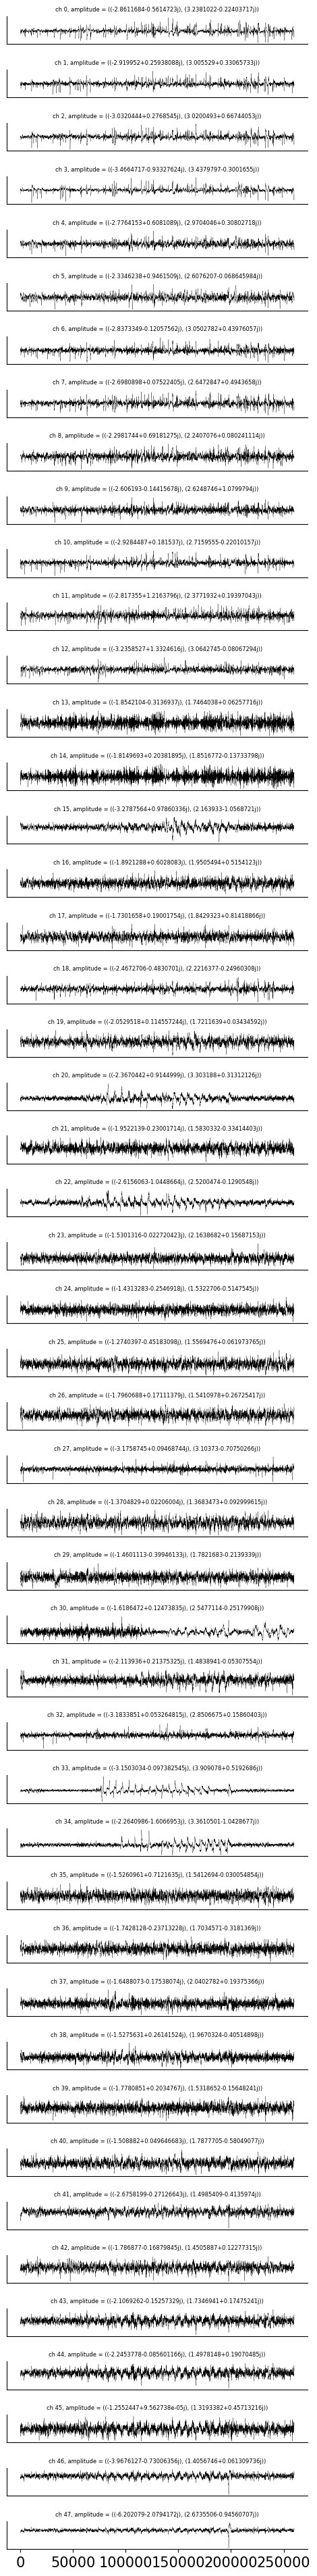

In [16]:
alldat = load_data()
dat = alldat[0][-1] #Take the last participant

#Filter the data
prep_func = Preprocessing()
channel_func = ChannelSelection()
regression_models = RegressionModels()
filtered_data = prep_func.band_pass(dat["V"], lp_freq = 200, hp_freq = 0.15, fs = 1000, order = 5)

fft_filtering(dat["V"])

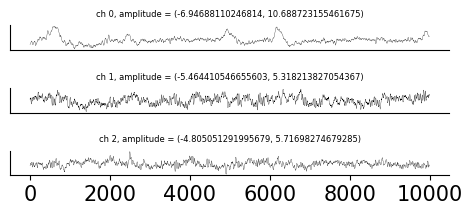

Explained Variance : 0.49500977768985915
(259920, 3)


In [4]:

num_pc = 3
pca_V, ev = channel_func.channel_pca(filtered_data, num_pc, get_explained_variance=True)

plot_signals(pca_V, window = [10000,20000])
print("Explained Variance :" , ev)

print(pca_V.shape)

## Linear regression on the X cursor

In [5]:
X_train,X_test, y_train, y_test = regression_models.temporal_split(pca_V,dat["cursorX"], test_size=0.2)
y_pred, train_score, test_score, coeffs, intercept = regression_models.linear_regression(X_train, X_test, y_train, y_test, return_all=True)
print(train_score, test_score)

0.0038212159675722335 -0.0016759263243795175


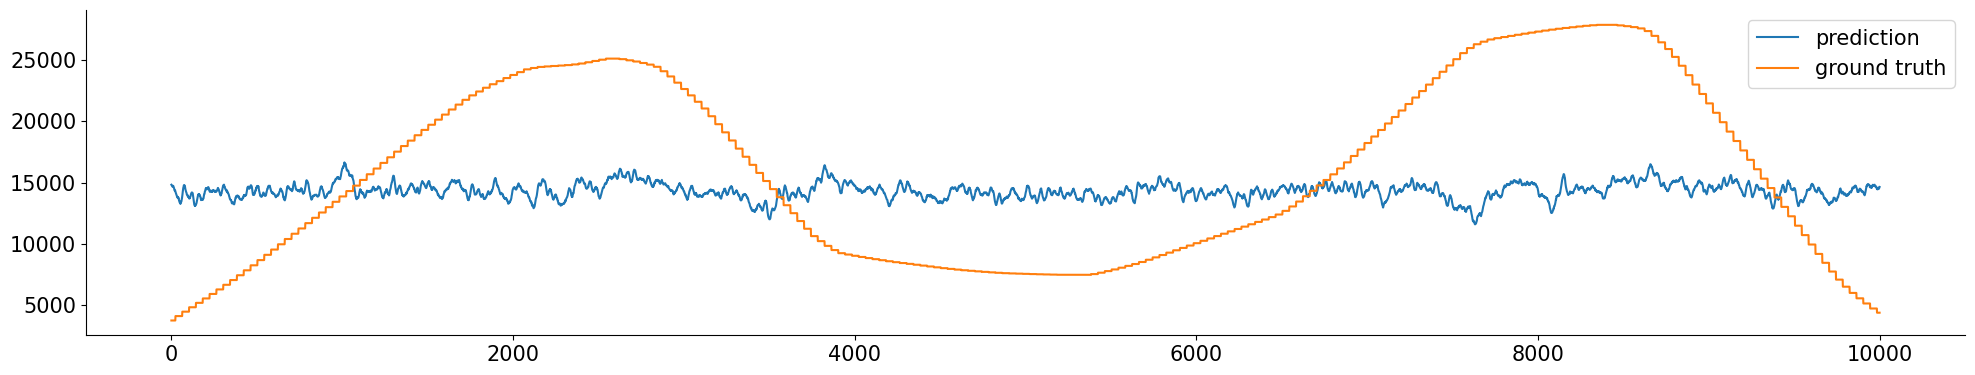

In [6]:
plt.plot(y_pred[10000:20000], label = "prediction")
plt.plot(y_test[10000:20000], label = "ground truth")
plt.legend()

## Ridge Regression on the X cursor

In [9]:
y_pred = regression_models.ridge_regression(X_train, X_test, y_train, y_test, alpha = 2 , return_all=False)

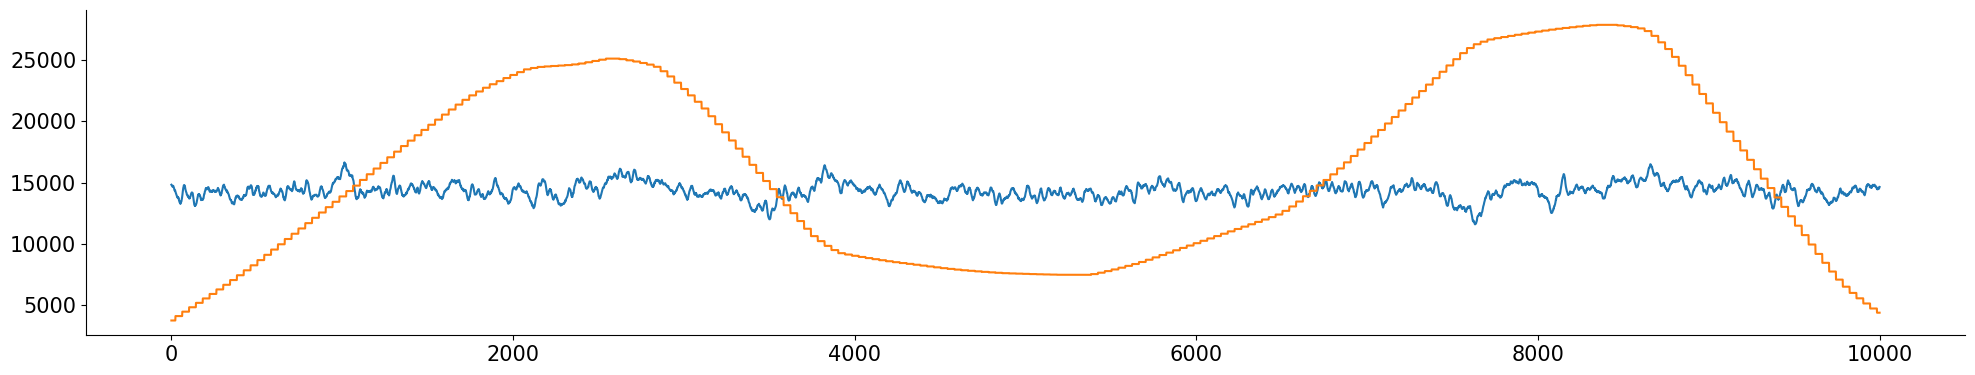

In [10]:
plt.plot(y_pred[10000:20000])
plt.plot(y_test[10000:20000])

## Channel by channel

In [26]:
filtered_data.shape

(259920, 48)

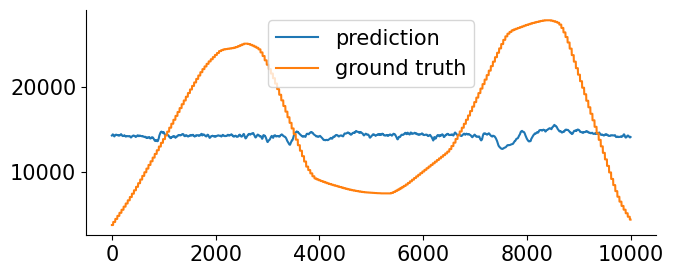

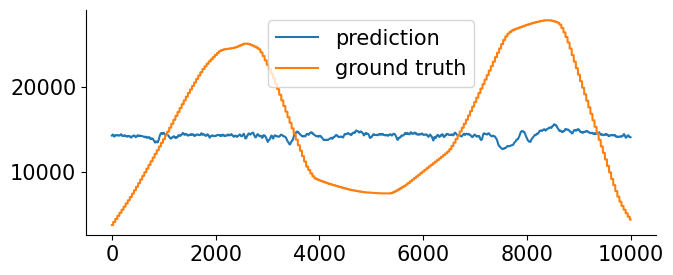

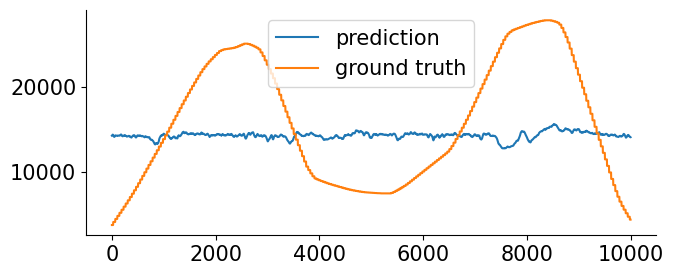

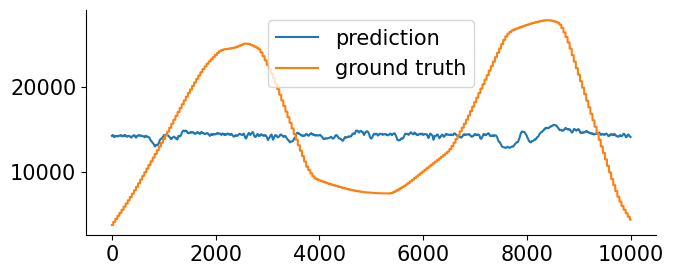

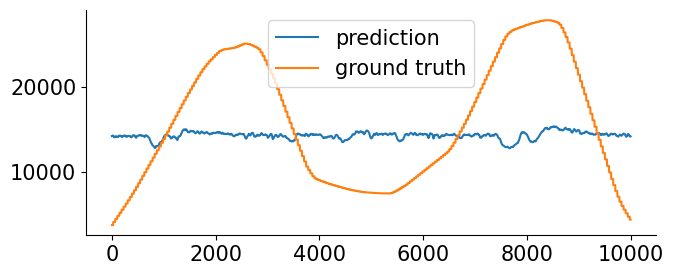

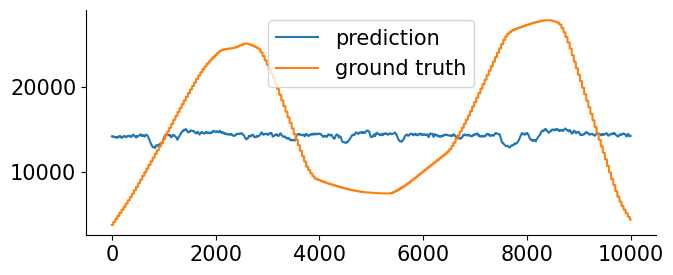

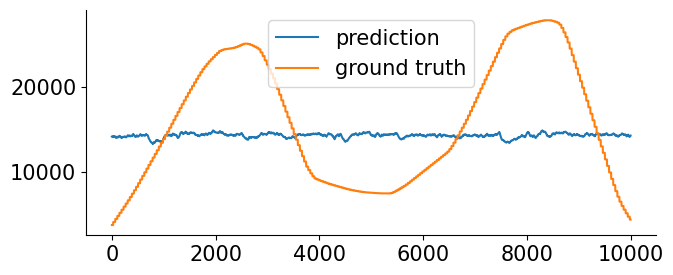

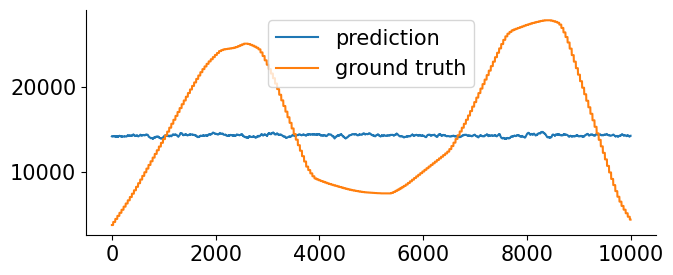

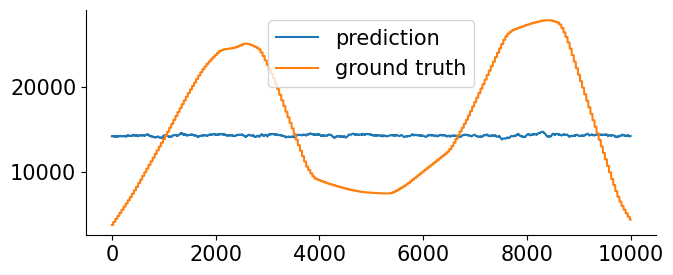

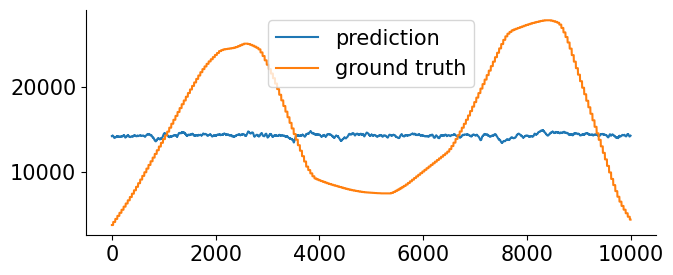

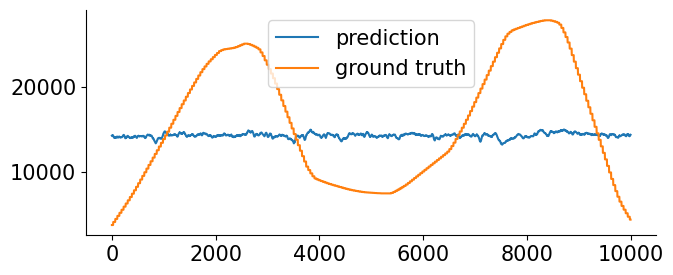

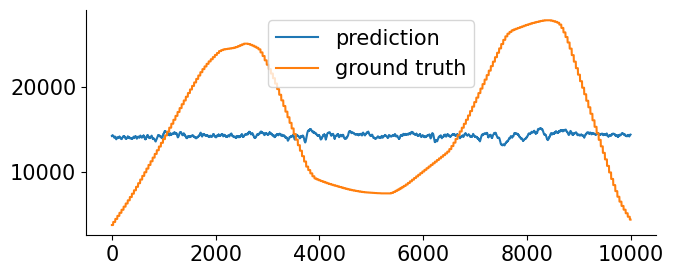

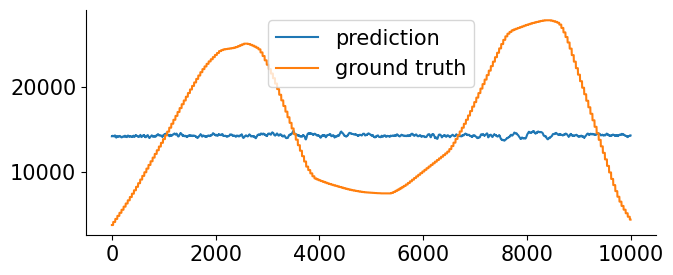

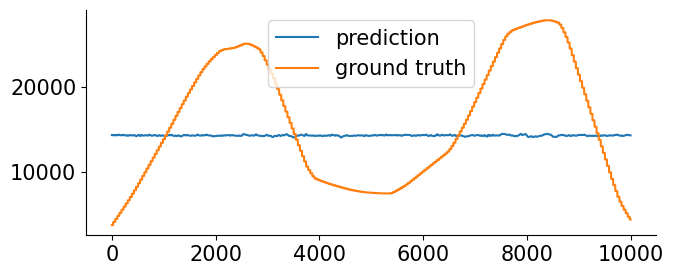

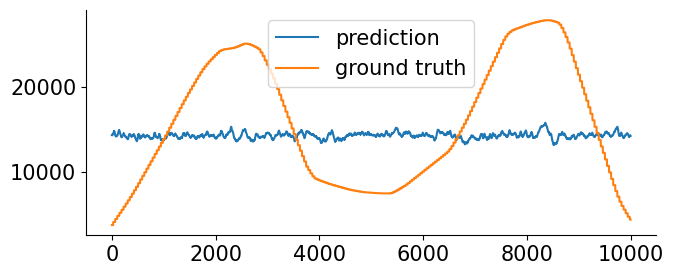

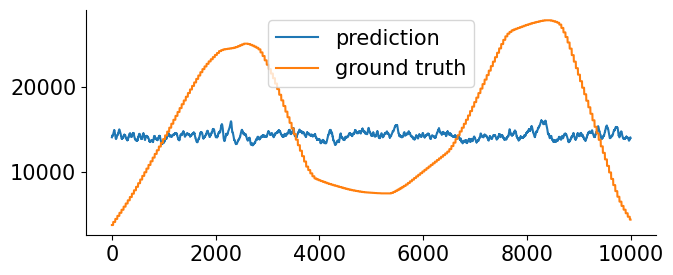

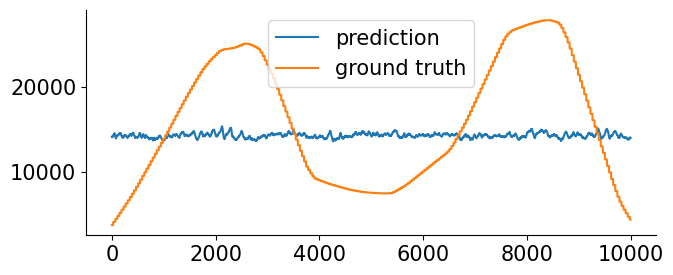

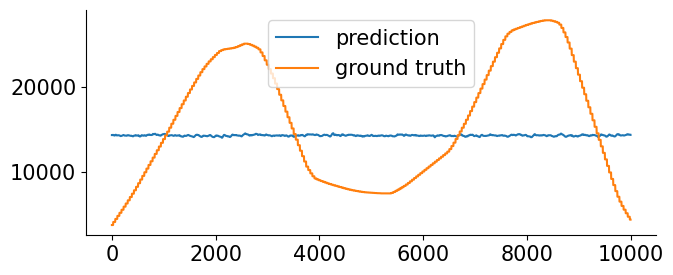

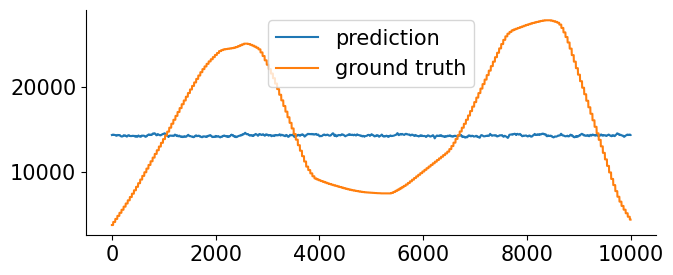

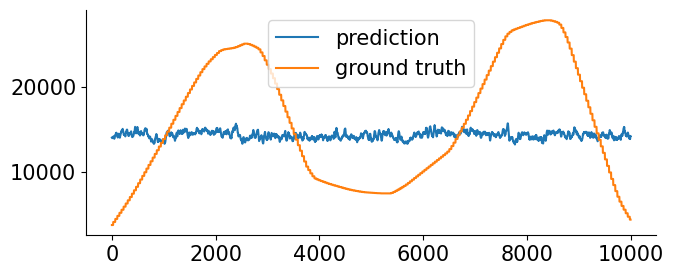

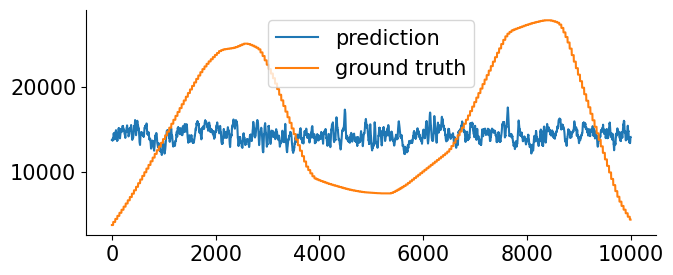

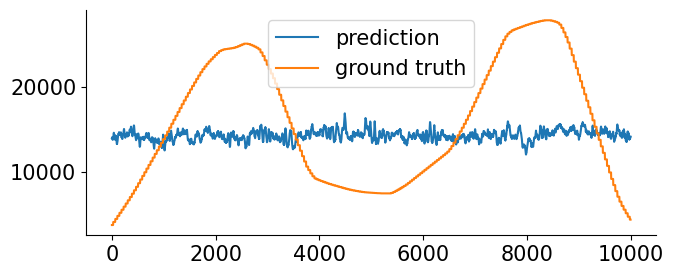

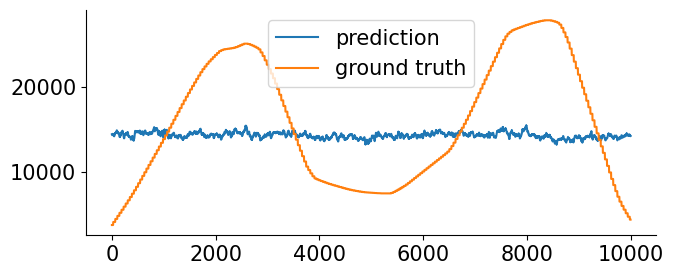

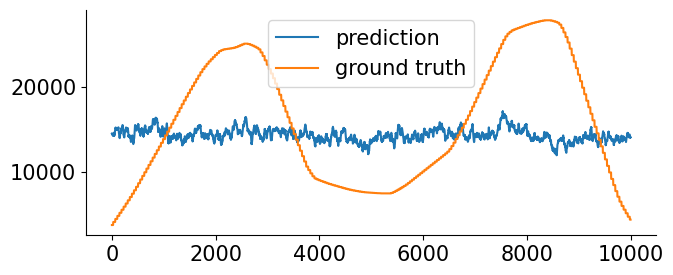

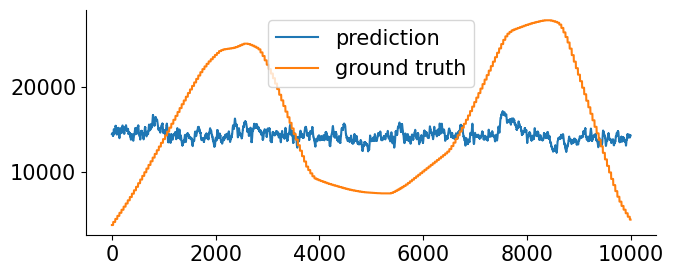

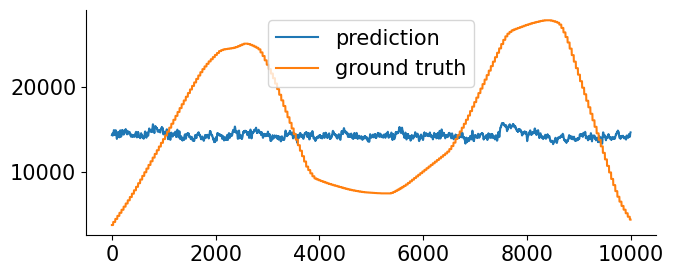

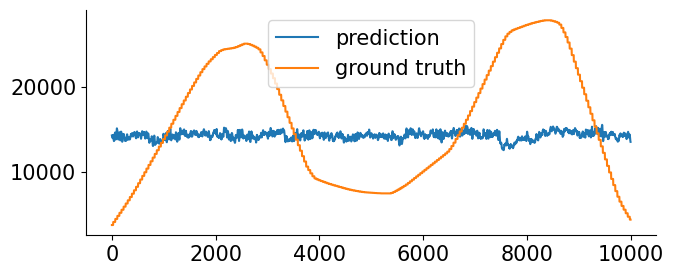

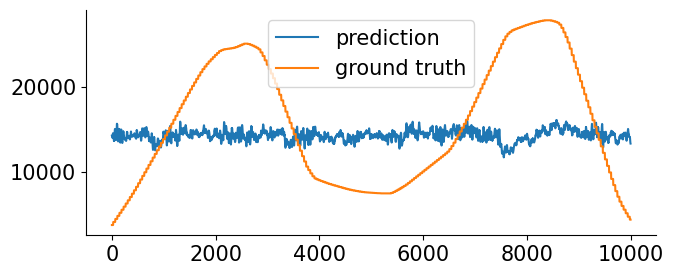

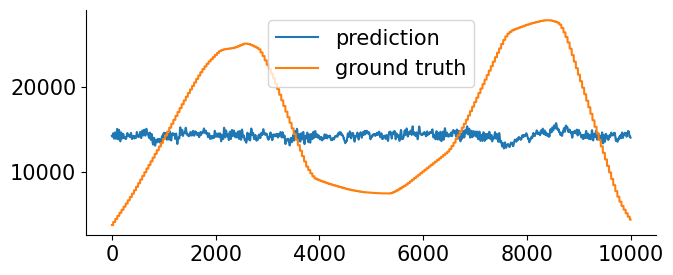

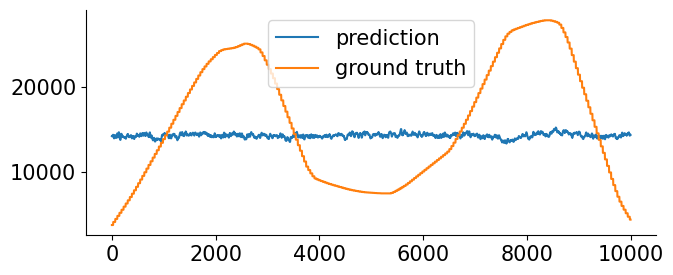

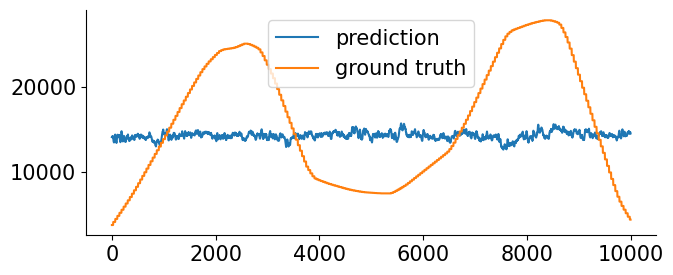

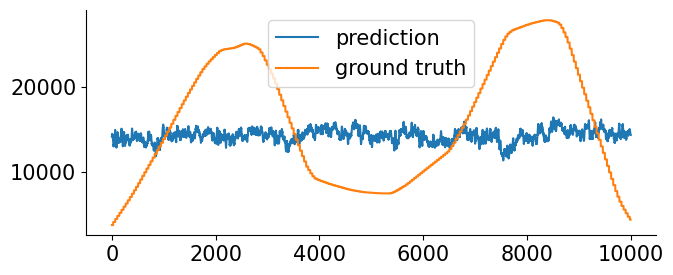

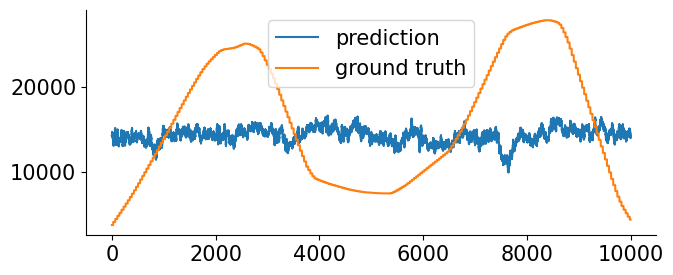

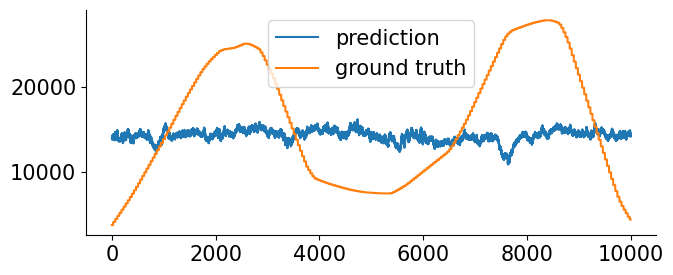

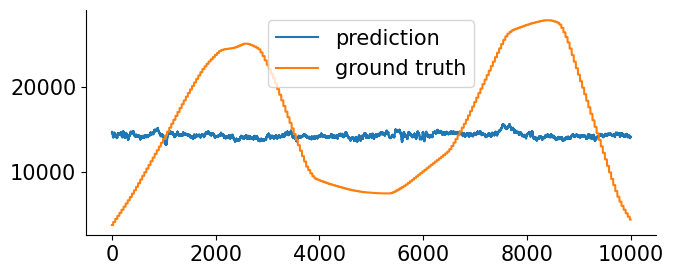

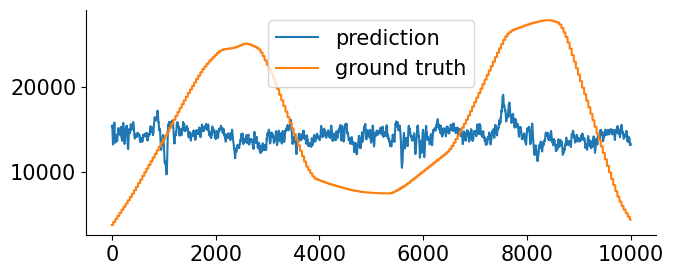

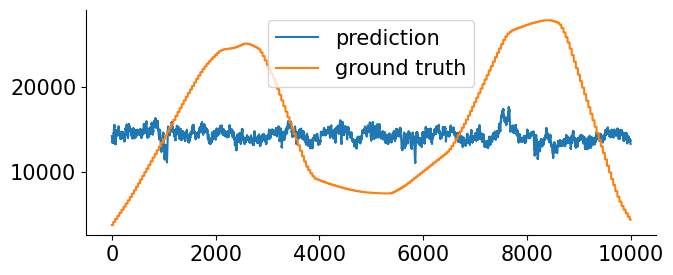

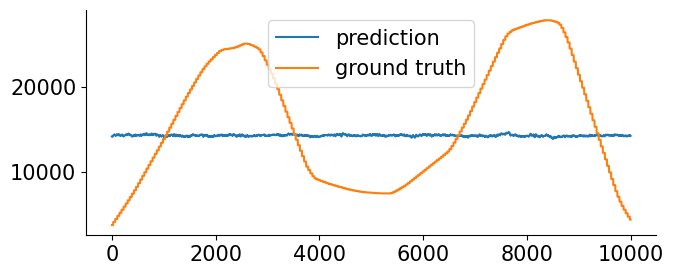

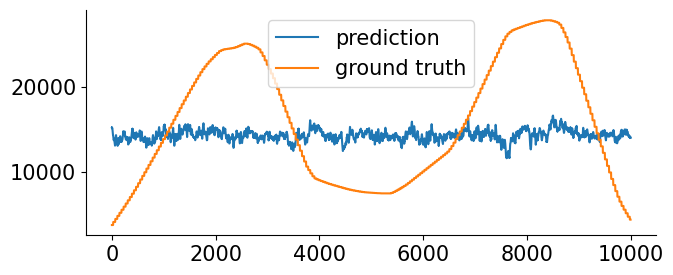

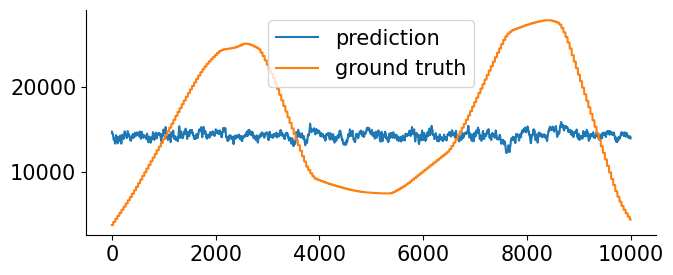

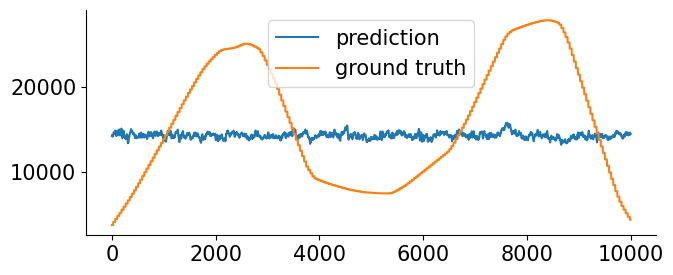

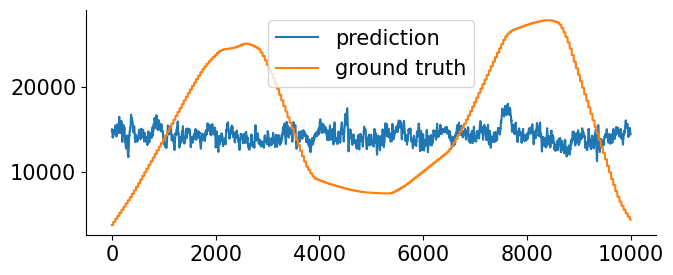

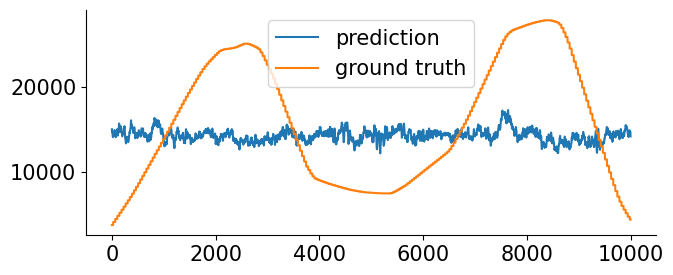

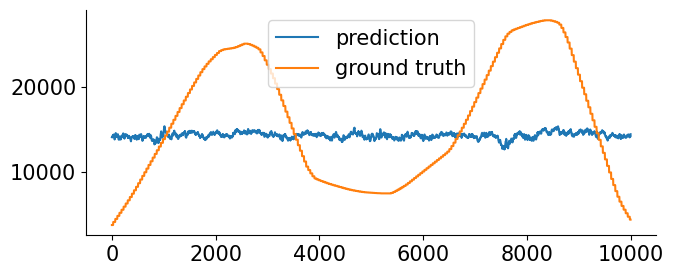

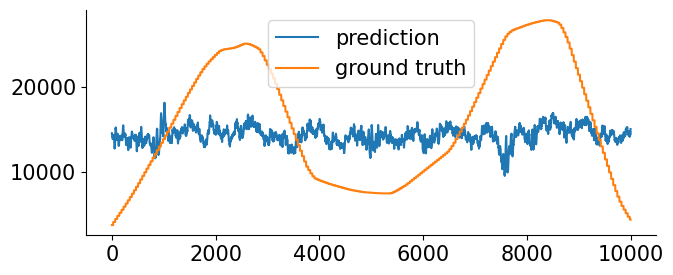

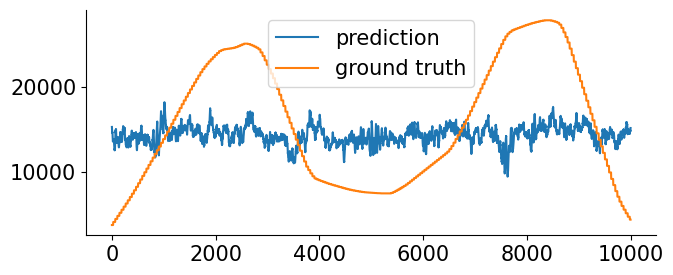

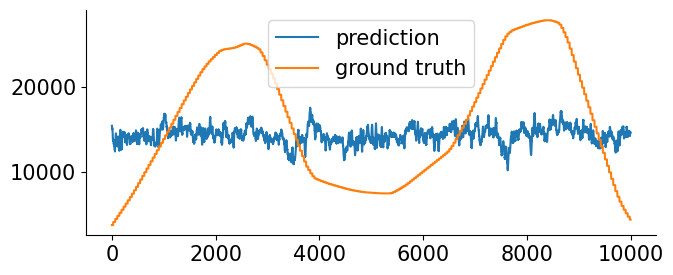

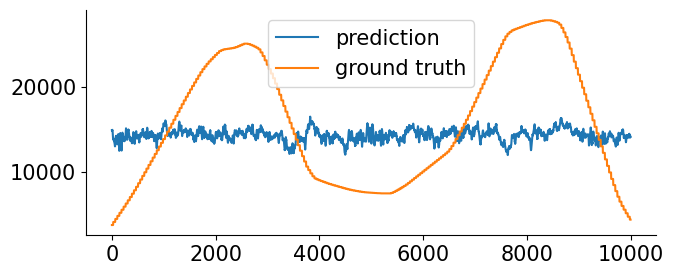

In [14]:
for c in range(filtered_data.shape[1]):
    single_channel = channel_func.specific_channel(filtered_data, channel_sel=c)
    X_train, X_test, y_train, y_test = regression_models.temporal_split(single_channel, dat["cursorX"], test_size=0.2)
    y_pred = regression_models.linear_regression(X_train, X_test, y_train, y_test, return_all=False)
    
    
    f = plt.figure(figsize = (7,3))
    plt.plot(y_pred[10000:20000], label = "prediction")
    plt.plot(y_test[10000:20000], label = "ground truth")
    plt.legend()
    plt.show() 